In [1]:
library(forecast)

In [2]:
data = read.csv(file="ETHBTC_1529613479999.csv", header=TRUE, sep=",")

In [3]:
close_ts = ts(data$CLOSE, frequency=1440)

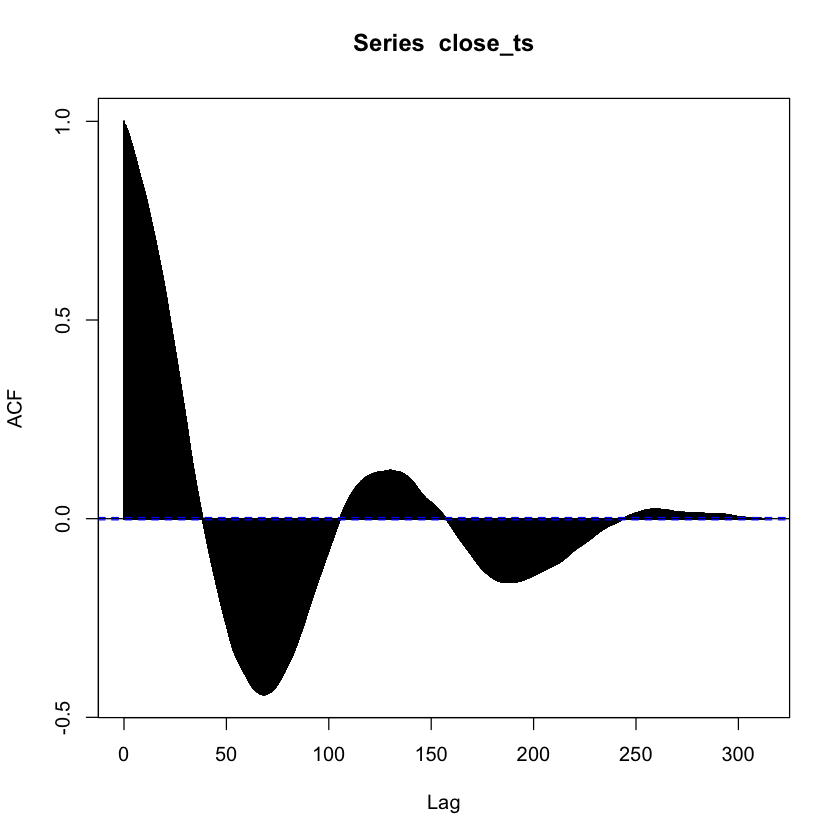

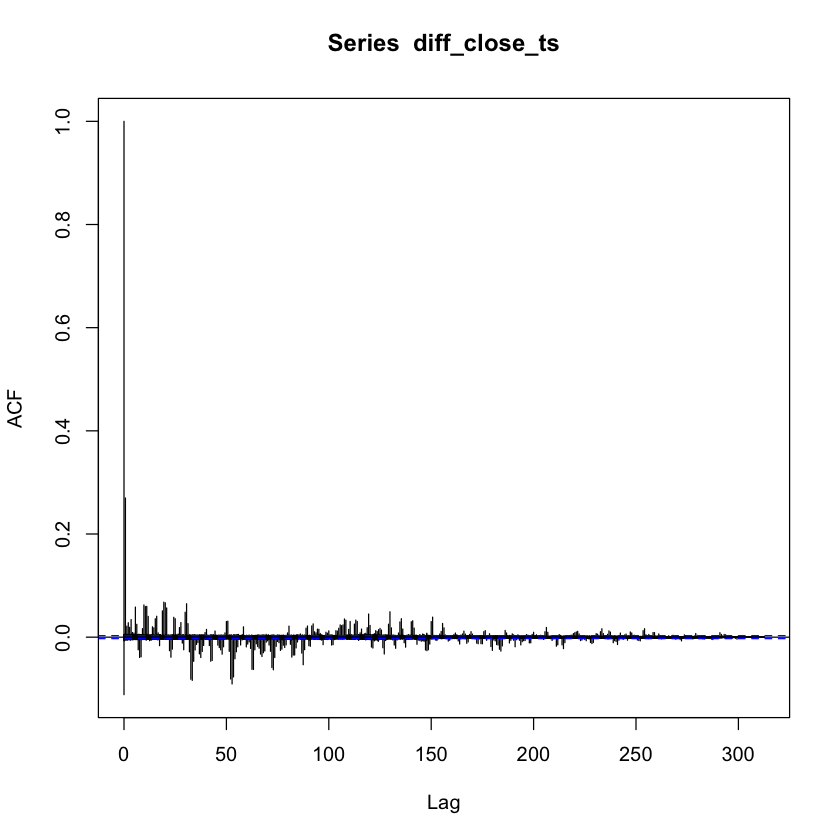

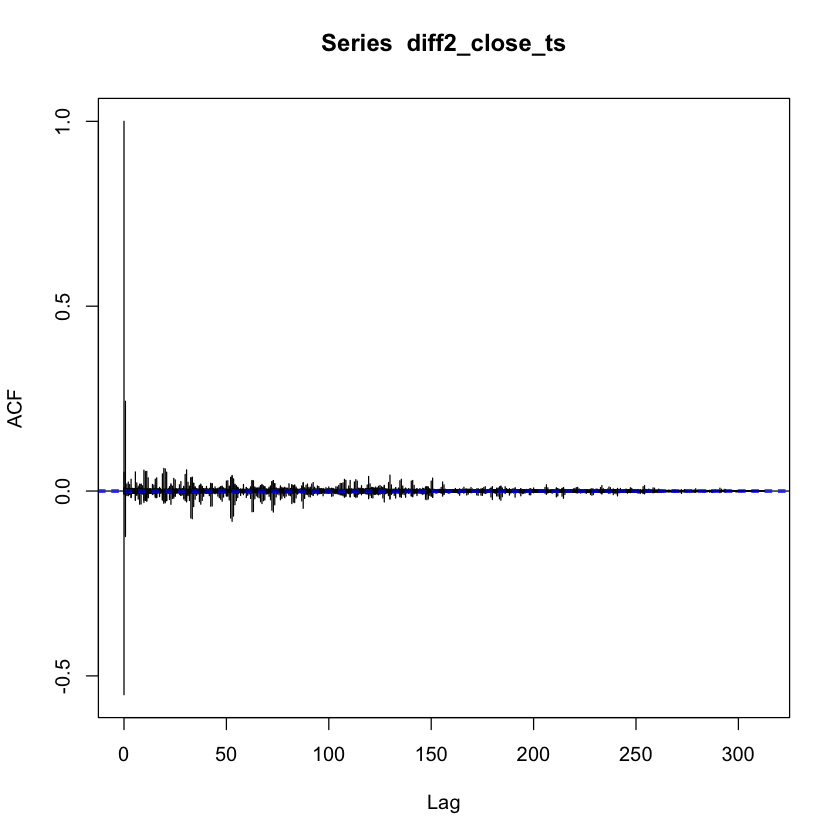

In [6]:
# ARIMA Modelling
# BoxCox.lambda(close_ts) # -> 0.966573424287734 Hence not using box cox transformation
xacf <- Acf(close_ts, lag.max = length(close_ts))

diff_close_ts = diff(close_ts)
diff_xacf <- Acf(diff_close_ts, lag.max = length(diff_close_ts))

diff2_close_ts = diff(diff_close_ts)
diff2_xacf <- Acf(diff2_close_ts, lag.max = length(diff2_close_ts))

In [14]:
Arima(close_ts, order=c(2,1,2))

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”

Series: close_ts 
ARIMA(2,1,2) 

Coefficients:
          ar1      ar2      ma1      ma2
      -0.0561  -0.0029  -0.0566  -0.0018
s.e.      NaN   0.0106      NaN      NaN

sigma^2 estimated as 2.186e-08:  log likelihood=3330173
AIC=-6660337   AICc=-6660337   BIC=-6660282

In [17]:
Arima(diff_close_ts, order=c(1,0,1))

Series: diff_close_ts 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
          ar1      ma1  mean
      -0.0158  -0.0969     0
s.e.   0.0130   0.0129     0

sigma^2 estimated as 2.186e-08:  log likelihood=3330173
AIC=-6660339   AICc=-6660339   BIC=-6660295

In [15]:
Arima(close_ts, order=c(5,1,5))

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”

Series: close_ts 
ARIMA(5,1,5) 

Coefficients:
          ar1      ar2    ar3     ar4    ar5      ma1      ma2    ma3     ma4
      -0.0561  -0.0023  0.001  0.0024  9e-04  -0.0566  -0.0024  5e-04  0.0023
s.e.      NaN      NaN    NaN     NaN    NaN      NaN      NaN    NaN     NaN
        ma5
      5e-04
s.e.    NaN

sigma^2 estimated as 2.186e-08:  log likelihood=3330179
AIC=-6660337   AICc=-6660337   BIC=-6660215

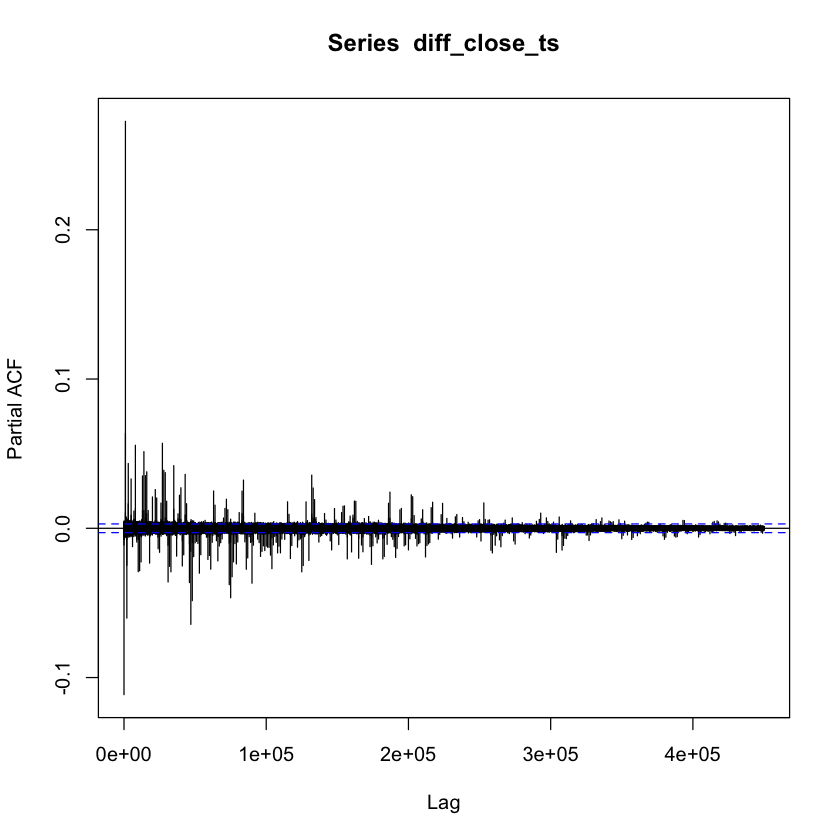

In [11]:
Pacf(diff_close_ts, lag.max = length(diff_close_ts))

In [ ]:
fh <- 10 #The forecasting horizon examined
frq <- 1440 #The frequency of the data

data_train = data_test <- NULL

data_train[1] = list(ts(head(data$CLOSE, length(data$CLOSE) - fh), frequency = frq))
data_test[1] = list(tail(data$CLOSE,fh))

In [ ]:
# Evaluation Metric
smape_cal <- function(outsample, forecasts){
  #Used to estimate sMAPE
  outsample <- as.numeric(outsample) ; forecasts<-as.numeric(forecasts)
  smape <- (abs(outsample-forecasts)*200)/(abs(outsample)+abs(forecasts))
  return(smape)
}

mase_cal <- function(insample, outsample, forecasts){
  #Used to estimate MASE
  frq <- frequency(insample)
  forecastsNaiveSD <- rep(NA,frq)
  for (j in (frq+1):length(insample)){
    forecastsNaiveSD <- c(forecastsNaiveSD, insample[j-frq])
  }
  masep<-mean(abs(insample-forecastsNaiveSD),na.rm = TRUE)
  
  outsample <- as.numeric(outsample) ; forecasts <- as.numeric(forecasts)
  mase <- (abs(outsample-forecasts))/masep
  return(mase)
}

In [ ]:
# Algos
naive_seasonal <- function(input, fh){
  #Used to estimate Seasonal Naive
  frcy <- frequency(input)
  frcst <- naive(input, h=fh)$mean 
  if (frcy>1){ 
    frcst <- head(rep(as.numeric(tail(input,frcy)), fh), fh) + frcst - frcst
  }
  return(frcst)
}

Theta.classic <- function(input, fh){
  #Used to estimate Theta classic
  
  #Set parameters
  wses <- wlrl<-0.5 ; theta <- 2
  #Estimate theta line (0)
  observations <- length(input)
  xt <- c(1:observations)
  xf <- c((observations+1):(observations+fh))
  train <- data.frame(input=input, xt=xt)
  test <- data.frame(xt = xf)
  
  estimate <- lm(input ~ poly(xt, 1, raw=TRUE))
  thetaline0In <- as.numeric(predict(estimate))
  thetaline0Out <- as.numeric(predict(estimate,test))
  
  #Estimate theta line (2)
  thetalineT <- theta*input+(1-theta)*thetaline0In
  sesmodel <- ses(thetalineT, h=fh)
  thetaline2In <- sesmodel$fitted
  thetaline2Out <- sesmodel$mean
  
  #Theta forecasts
  forecastsIn <- (thetaline2In*wses)+(thetaline0In*wlrl)
  forecastsOut <- (thetaline2Out*wses)+(thetaline0Out*wlrl)
  
  #Zero forecasts become positive
  for (i in 1:length(forecastsOut)){
    if (forecastsOut[i]<0){ forecastsOut[i]<-0 }
  }
  
  output=list(fitted = forecastsIn, mean = forecastsOut,
              fitted0 = thetaline0In, mean0 = thetaline0Out,
              fitted2 = thetaline2In, mean2 = thetaline2Out)
  
  return(output)
}

In [ ]:
# Helper Functions
SeasonalityTest <- function(input, ppy){
  #Used to determine whether a time series is seasonal
  tcrit <- 1.645
  if (length(input)<3*ppy){
    test_seasonal <- FALSE
  }else{
    xacf <- acf(input, plot = FALSE)$acf[-1, 1, 1]
    clim <- tcrit/sqrt(length(input)) * sqrt(cumsum(c(1, 2 * xacf^2)))
    test_seasonal <- ( abs(xacf[ppy]) > clim[ppy] )
    
    if (is.na(test_seasonal)==TRUE){ test_seasonal <- FALSE }
  }
  
  return(test_seasonal)
}

In [ ]:
input = data_train[[1]]
ndiffs(input)

In [ ]:
diff_input = diff(input)

In [ ]:
diff2_input = diff(diff_input)
diff2_xacf <- acf(diff2_input, lag.max = length(diff2_input), plot = FALSE)$acf[-1, 1, 1]
plot(diff2_xacf)

In [ ]:
plot(diff2_xacf)

In [ ]:
xacf <- acf(diff_input, lag.max = length(diff_input), plot = FALSE)$acf[-1, 1, 1]
plot(xacf)

In [ ]:
input = data_train[[1]]
xacf <- acf(input, lag.max = length(input), plot = FALSE)$acf[-1, 1, 1]
plot(xacf)

In [ ]:
input = data_train[[1]]

ppy <- frequency(input)
ST <- F

Dec <- decompose(input,type="multiplicative")
des_input <- input/Dec$seasonal
SIout <- head(rep(Dec$seasonal[(length(Dec$seasonal)-ppy+1):length(Dec$seasonal)], fh), fh)

In [ ]:
print('DONE')

In [ ]:
f1 <- naive(input, h=fh)$mean #Naive

In [ ]:
Benchmarks <- function(input, fh){
  f1 <- naive(input, h=fh)$mean #Naive
    print('Naive DONE')
  f2 <- naive_seasonal(input, fh=fh) #Seasonal Naive
    print('Seasonal Naive DONE')
  f3 <- naive(des_input, h=fh)$mean*SIout #Naive2
    print('Naive2 DONE')
  f4 <- ses(des_input, h=fh)$mean*SIout #Ses
    print('Ses DONE')
  f5 <- holt(des_input, h=fh, damped=F)$mean*SIout #Holt
    print('Holt DONE')
  f6 <- holt(des_input, h=fh, damped=T)$mean*SIout #Damped
    print('Damped DONE')
  f7 <- Theta.classic(input=des_input, fh=fh)$mean*SIout #Theta
    print('Theta DONE')
  f8 <- (f4+f5+f6)/3 #Comb
    return(list(f1, f2, f3, f4, f5, f6, f7, f8))
}
print('pre loop started')
# Names_benchmarks <- c("Naive", "sNaive", "Naive2", "SES", "Holt", "Damped", "Theta", "Com")
Names_benchmarks <- c("Naive", "sNaive", "Naive2", "SES", "Holt", "Damped", "Theta", "Com")
print('pre loop started')
Total_smape = Total_mase <- array(NA,dim = c(length(Names_benchmarks), fh, length(data_train)))
print('pre loop started')
#Methods, Horizon, time-series
for (i in 1:length(data_train)){
  print('loop started')
    
  insample <- data_train[[i]]
  outsample <- data_test[[i]]
  forecasts <- Benchmarks(input=insample, fh=fh)
  
  #sMAPE
  for (j in 1:length(Names_benchmarks)){
      Total_smape[j,,i] <- smape_cal(outsample, forecasts[[j]]) #j the # of the benchmark
  }
  #MASE
  # for (j in 1:length(Names_benchmarks)){
  #     Total_mase[j,,i] <- mase_cal(insample, outsample, forecasts[[j]]) #j the # of the benchmark
  # }
}

print("########### sMAPE ###############")
for (i in 1:length(Names_benchmarks)){
  print(paste(Names_benchmarks[i], round(mean(Total_smape[i,,]), 3)))
}
# print("########### MASE ################")
# for (i in 1:length(Names_benchmarks)){
#   print(paste(Names_benchmarks[i], round(mean(Total_mase[i,,]), 3)))
# }
# print("########### OWA ################")
# for (i in 1:length(Names_benchmarks)){
#   print(paste(Names_benchmarks[i],
#               round(((mean(Total_mase[i,,])/mean(Total_mase[3,,]))+(mean(Total_smape[i,,])/mean(Total_smape[3,,])))/2, 3)))
# }

In [ ]:
for (i in 1:length(data_train)){
    print('loop started')
}